In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from skrebate import ReliefF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

files = [
    ("data/processed.cleveland.data", "cleveland"),
    ("data/processed.hungarian.data", "hungarian"),
    ("data/processed.switzerland.data", "switzerland"),
    ("data/processed.va.data", "va")
]

# Load data with source tracking
dfs = []
for file_path, source in files:
    temp_df = pd.read_csv(file_path, 
                         names=column_names, 
                         na_values='?',
                         header=None)
    temp_df['source'] = source
    dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True)

# Convert columns to numeric, binarize target
for col in column_names:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Impute missing values by source with KNNImputer
dfs_imputed = []
for source in df['source'].unique():
    temp = df[df['source'] == source].copy()
    numeric_cols = temp.select_dtypes(include=[np.number]).columns.drop('target')
    n_neighbors = min(5, len(temp) - 1)
    imputer = KNNImputer(n_neighbors=n_neighbors)
    temp[numeric_cols] = imputer.fit_transform(temp[numeric_cols])
    dfs_imputed.append(temp)

df = pd.concat(dfs_imputed, ignore_index=True)

# One-hot encode 'source'
df = pd.get_dummies(df, columns=['source'], prefix='src')

# Separate features and target
X = df.drop('target', axis=1)
y = df['target'].values

# Fill any remaining NaNs with median (just in case)
X = X.fillna(X.median())

# Scale all features BEFORE feature selection (ReliefF requires numeric, scaled data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# For chi2, features must be non-negative; create separate variable for that
X_nonneg = X_scaled - X_scaled.min(axis=0)

selectors = {
    "PCA": PCA(n_components=10),
    "ChiSq": SelectKBest(chi2, k=10),
    "ReliefF": ReliefF(n_features_to_select=10),
    "SyUn": SelectKBest(mutual_info_classif, k=10)
}

model = RandomForestClassifier(random_state=42)
results = {}

for name, selector in selectors.items():
    print(f"\n=== Running pipeline with {name} feature selection ===")
    
    if name == "ChiSq":
        X_selected = selector.fit_transform(X_nonneg, y)
    else:
        X_selected = selector.fit_transform(X_scaled, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42, stratify=y
    )

    # Balance training data with SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Scaling again after resampling
    scaler_inner = StandardScaler()
    X_train_scaled = scaler_inner.fit_transform(X_train_res)
    X_test_scaled = scaler_inner.transform(X_test)

    # Train model
    model.fit(X_train_scaled, y_train_res)

    # Predict and evaluate
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    print(f"AUC: {auc:.4f}, Accuracy: {acc:.4f}")
    results[name] = {"AUC": auc, "Accuracy": acc}

print("\nSummary of results:")
for k, v in results.items():
    print(f"{k}: AUC={v['AUC']:.4f}, Accuracy={v['Accuracy']:.4f}")


=== Running pipeline with PCA feature selection ===
AUC: 0.9244, Accuracy: 0.8641

=== Running pipeline with ChiSq feature selection ===
AUC: 0.9104, Accuracy: 0.8315

=== Running pipeline with ReliefF feature selection ===
AUC: 0.9087, Accuracy: 0.8315

=== Running pipeline with SyUn feature selection ===
AUC: 0.9216, Accuracy: 0.8370

Summary of results:
PCA: AUC=0.9244, Accuracy=0.8641
ChiSq: AUC=0.9104, Accuracy=0.8315
ReliefF: AUC=0.9087, Accuracy=0.8315
SyUn: AUC=0.9216, Accuracy=0.8370


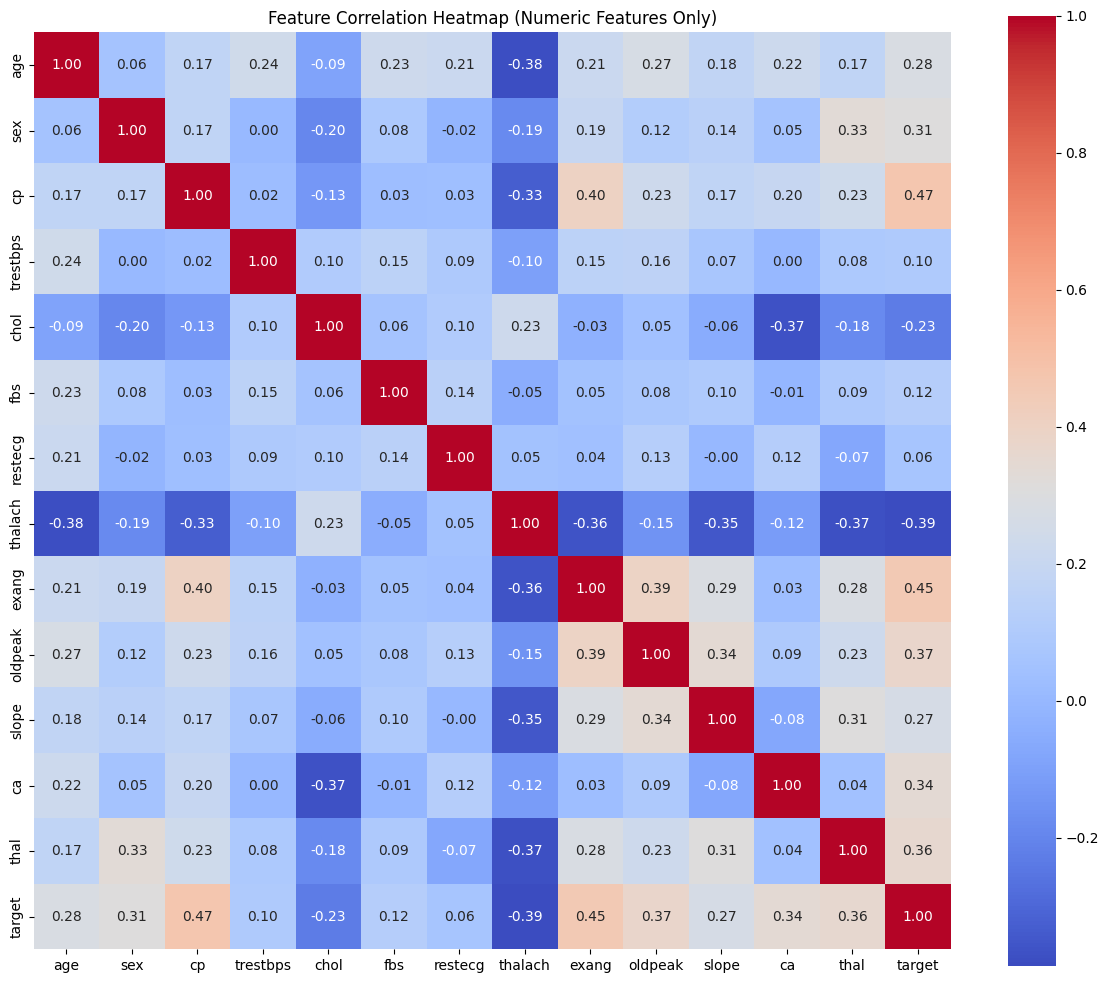

Correlation with target:
target      1.000000
cp          0.471712
exang       0.453711
oldpeak     0.374086
thal        0.359172
ca          0.340599
sex         0.307284
age         0.282700
slope       0.265844
fbs         0.119675
trestbps    0.100143
restecg     0.062807
chol       -0.230882
thalach    -0.387137
Name: target, dtype: float64


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap (Numeric Features Only)")
plt.tight_layout()  # Prevent label cutoff
plt.show()

print("Correlation with target:")
print(corr_matrix["target"].sort_values(ascending=False))

In [6]:
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
)

from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


# your models dict from before
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

pipelines = {}
for name, model in models.items():
    if name == "XGBoost":
        #  TODO: xgboost needs more polish for better results
        # For XGBoost, no StandardScaler
        pipelines[name] = Pipeline([
            ("smote", SMOTE(random_state=42)),
            ("xgb", model)
        ])
    else:
        # For others, use StandardScaler + SMOTE
        pipelines[name] = make_pipeline(
            StandardScaler(),
            SMOTE(random_state=42),
            model
        )

# 10-fold stratified CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

results = {}
for name, pipe in pipelines.items():
    cv_res = cross_validate(
        pipe,
        X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    # compute mean ± std for each metric
    summary = {
        metric: (cv_res[f"test_{metric}"].mean(), cv_res[f"test_{metric}"].std())
        for metric in scoring
    }
    results[name] = summary

# Flatten results dict
flat_results = {}
for model_name, metrics in results.items():
    flat_metrics = {}
    for metric, (mean, std) in metrics.items():
        flat_metrics[f"{metric}_mean"] = mean
        flat_metrics[f"{metric}_std"] = std
    flat_results[model_name] = flat_metrics

# Create DataFrame
df = pd.DataFrame(flat_results).T

# Sort by ROC AUC mean
df = df.sort_values("roc_auc_mean", ascending=False)

# Round for readability
print(df.round(4))

                     accuracy_mean  accuracy_std  precision_mean  \
Logistic Regression         0.8228        0.0392          0.8523   
SVM                         0.8283        0.0373          0.8437   
Random Forest               0.8098        0.0331          0.8231   
KNN                         0.8196        0.0441          0.8451   
XGBoost                     0.7957        0.0434          0.8061   
Decision Tree               0.7261        0.0547          0.7632   

                     precision_std  recall_mean  recall_std  f1_mean  f1_std  \
Logistic Regression         0.0333       0.8232      0.0625   0.8363  0.0395   
SVM                         0.0285       0.8468      0.0606   0.8442  0.0388   
Random Forest               0.0319       0.8370      0.0401   0.8295  0.0303   
KNN                         0.0389       0.8251      0.0558   0.8344  0.0434   
XGBoost                     0.0280       0.8292      0.0599   0.8171  0.0426   
Decision Tree               0.0556       0.

In [7]:
import pandas as pd

results = {
    'Logistic Regression': {
        'Accuracy': 0.8667,
        'Precision': 0.8333,
        'Recall': 0.8333,
        'F1 Score': 0.8333,
        'ROC AUC': 0.9421
    },
    'Decision Tree': {
        'Accuracy': 0.8167,
        'Precision': 0.7407,
        'Recall': 0.8333,
        'F1 Score': 0.7843,
        'ROC AUC': 0.8194
    },
    'Random Forest': {
        'Accuracy': 0.8833,
        'Precision': 0.84,
        'Recall': 0.875,
        'F1 Score': 0.8571,
        'ROC AUC': 0.9404
    },
    'SVM': {
        'Accuracy': 0.8833,
        'Precision': 0.8696,
        'Recall': 0.8333,
        'F1 Score': 0.8511,
        'ROC AUC': 0.9537
    },
    'KNN': {
        'Accuracy': 0.8333,
        'Precision': 0.8182,
        'Recall': 0.75,
        'F1 Score': 0.7826,
        'ROC AUC': 0.9398
    },
    'XGBoost': {
        'Accuracy': 0.8333,
        'Precision': 0.75,
        'Recall': 0.875,
        'F1 Score': 0.8077,
        'ROC AUC': 0.8947
    },
}

df = pd.DataFrame(results).T
df = df.sort_values(by='F1 Score', ascending=False)
print(df)

                     Accuracy  Precision  Recall  F1 Score  ROC AUC
Random Forest          0.8833     0.8400  0.8750    0.8571   0.9404
SVM                    0.8833     0.8696  0.8333    0.8511   0.9537
Logistic Regression    0.8667     0.8333  0.8333    0.8333   0.9421
XGBoost                0.8333     0.7500  0.8750    0.8077   0.8947
Decision Tree          0.8167     0.7407  0.8333    0.7843   0.8194
KNN                    0.8333     0.8182  0.7500    0.7826   0.9398


In [8]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
        ('svm', SVC(probability=True)),
        ('knn', KNeighborsClassifier()),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ],
    voting='soft'  # use 'hard' for label-based voting
)

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

print("\n=== Voting Classifier (Soft Voting) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/home/arash/.pyenv/versions/3.11.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:03:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Voting Classifier (Soft Voting) ===
Accuracy: 0.8478260869565217
Precision: 0.8627450980392157
Recall: 0.8627450980392157
F1 Score: 0.8627450980392157
ROC AUC: 0.9201339072214252
Confusion Matrix:
 [[68 14]
 [14 88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        82
           1       0.86      0.86      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



In [9]:
from sklearn.ensemble import StackingClassifier

base_learners = [
    ('lr', LogisticRegression()),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    passthrough=True,  # include original features for meta model
    cv=5
)

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
y_proba = stacking_clf.predict_proba(X_test)[:, 1]

print("\n=== Stacking Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/home/arash/.pyenv/versions/3.11.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:03:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/3.11.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:03:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Stacking Classifier ===
Accuracy: 0.8315217391304348
Precision: 0.8446601941747572
Recall: 0.8529411764705882
F1 Score: 0.848780487804878
ROC AUC: 0.9163079866092778
Confusion Matrix:
 [[66 16]
 [15 87]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81        82
           1       0.84      0.85      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184



In [10]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import (RandomizedSearchCV, cross_val_score, StratifiedKFold)
import numpy as np

# define parameter grids
rf_param = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2,5,10]
}
xgb_param = {
    "n_estimators": [50,100,200],
    "max_depth": [3,5,7],
    "learning_rate": [0.01,0.1,0.2]
}

# outer CV (for CI)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# inner CV + random search
def nested_score(model, param_grid):
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    search = RandomizedSearchCV(
        model, param_distributions=param_grid,
        n_iter=10, scoring="roc_auc", cv=inner_cv,
        random_state=42, n_jobs=-1
    )
    scores = cross_val_score(search, X, y,
                             scoring="roc_auc",
                             cv=outer_cv, n_jobs=-1)
    print(f"{model.__class__.__name__}: {scores.mean():.3f} ± {scores.std():.3f}")

nested_score(RandomForestClassifier(random_state=42), rf_param)
nested_score(XGBClassifier(eval_metric="logloss", random_state=42), xgb_param)

RandomForestClassifier: 0.900 ± 0.021
XGBClassifier: 0.896 ± 0.022


Epoch 1/30
19/19 - 1s - loss: 0.7365 - auc: 0.8219 - val_loss: 0.6919 - val_auc: 0.8805 - lr: 0.0010 - 1s/epoch - 72ms/step
Epoch 2/30
19/19 - 0s - loss: 0.6466 - auc: 0.8835 - val_loss: 0.5908 - val_auc: 0.8875 - lr: 0.0010 - 77ms/epoch - 4ms/step
Epoch 3/30
19/19 - 0s - loss: 0.5739 - auc: 0.8841 - val_loss: 0.5434 - val_auc: 0.8903 - lr: 0.0010 - 97ms/epoch - 5ms/step
Epoch 4/30
19/19 - 0s - loss: 0.5352 - auc: 0.8832 - val_loss: 0.5035 - val_auc: 0.8933 - lr: 0.0010 - 127ms/epoch - 7ms/step
Epoch 5/30
19/19 - 0s - loss: 0.5129 - auc: 0.8826 - val_loss: 0.4821 - val_auc: 0.8951 - lr: 0.0010 - 127ms/epoch - 7ms/step
Epoch 6/30
19/19 - 0s - loss: 0.4998 - auc: 0.8858 - val_loss: 0.4773 - val_auc: 0.8962 - lr: 0.0010 - 127ms/epoch - 7ms/step
Epoch 7/30
19/19 - 0s - loss: 0.4877 - auc: 0.8870 - val_loss: 0.4785 - val_auc: 0.8954 - lr: 0.0010 - 120ms/epoch - 6ms/step
Epoch 8/30
19/19 - 0s - loss: 0.4714 - auc: 0.8983 - val_loss: 0.4731 - val_auc: 0.8971 - lr: 0.0010 - 114ms/epoch - 6ms/s

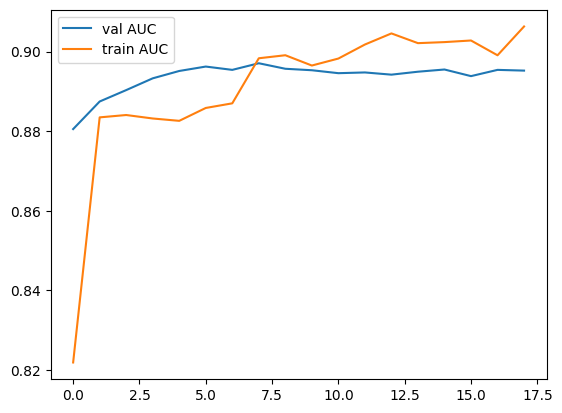

In [13]:
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing - scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train.astype(np.float32),
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

def build_encoder(input_dim):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="swish", kernel_regularizer=regularizers.l2(1e-3))(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="swish", kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation="swish", kernel_regularizer=regularizers.l2(1e-3))(x)
    return models.Model(inp, x)

encoder = build_encoder(X_tr.shape[1])

head_in = layers.Input(shape=(16,))
x = layers.Dense(8, activation="swish")(head_in)
out = layers.Dense(1, activation="sigmoid")(x)
head = models.Model(head_in, out)

inp = encoder.input
logit = head(encoder.output)
model = models.Model(inp, logit)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["AUC"]
)

early_stop = callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, min_lr=1e-6, mode='max')

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

dl_train_preds = model.predict(X_train_scaled)
dl_val_preds = model.predict(X_val)

plt.plot(history.history["val_auc"], label="val AUC")
plt.plot(history.history["auc"], label="train AUC")
plt.legend()
plt.show()

`VIF` stands for Variance Inflation Factor, a diagnostic tool used in regression analysis to detect multicollinearity among independent variables.

Multicollinearity occurs when one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. This messes with your estimates of coefficients — making them unstable and inflating their variances.

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''